#### Imports

In [1]:
import os
if os.path.basename(os.getcwd()) != 'Learning-Dynamic-Systems': os.chdir(".\\..")

from indirect_identification.sps_indirect import SPS_indirect_model
from indirect_identification.armax import ARMAX
from optimal_controller.lowres_MVEE import *
from optimal_controller.optimal_controls import get_hull
from fusion.fusion import scatter3d, get_ranks, sample_fused_rank_tensor, fuse_ranks, construct_p_tensor
from scipy.spatial import ConvexHull

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.cm import get_cmap
import os

np.random.seed(42)

### Fusion (via SPS ranks)

##### Define an ARX system, generate input/output data

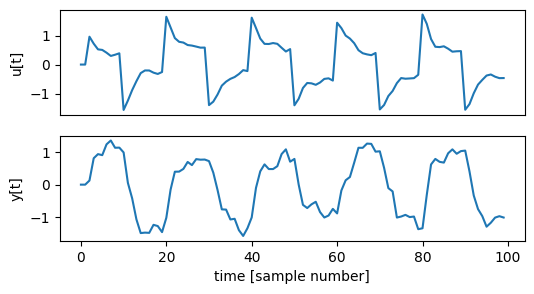

In [2]:
a = 0.8
b = 0.4
A = [1, -a]   # A(z^-1) = 1 - 0.33z^-1
B = [b]       # B(z^-1) = 0.22z^-1
C = [1, 0.15]    # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]          # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)
n_samples = 100
R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,3))
ax = ax.flatten()
ax[0].plot(U)
ax[0].set_xticks([])
ax[0].set_ylabel('u[t]')
ax[1].plot(Y)
ax[1].set_ylabel('y[t]')
ax[1].set_xlabel('time [sample number]')
plt.show()

##### Demonstrate fusion of two different confidence regions

In [3]:
F = ([0.31, 0.23], [1])
L = ([1], [1])
n_a = 1
n_b = 1

search_ranges = [[0.6, 0.8], [0.25, 0.55]] # a range, b range
search_resolutions = [50,50]
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_resolutions[i]) for i in range(n_a+n_b)]
grid_vals = np.meshgrid(*grid_axes, indexing='ij')
grid_vals = np.array(grid_vals)

m = 50
q = 1
model = SPS_indirect_model(m, q)
conf_region1 = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)

m = 5
q = 1
model = SPS_indirect_model(m, q)
conf_region2 = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)


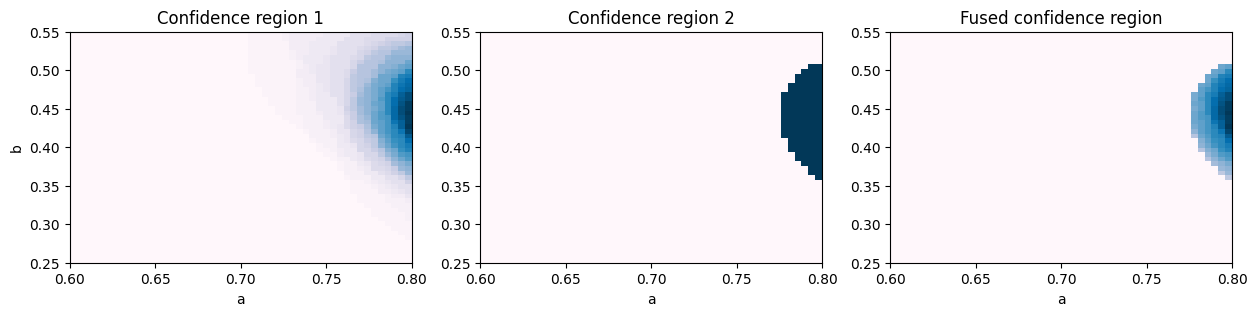

In [4]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,3))

axes[0].set_title("Confidence region 1")
axes[0].imshow(conf_region1.T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])
axes[0].set_aspect('auto')
axes[0].set_xlabel('a')
axes[0].set_ylabel('b')

axes[1].set_title("Confidence region 2")
axes[1].imshow(conf_region2.T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])
axes[1].set_aspect('auto')
axes[1].set_xlabel('a')

conf_region = fuse_ranks(conf_region1, conf_region2)

axes[2].set_title("Fused confidence region")
axes[2].imshow(conf_region.T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])
axes[2].set_aspect('auto')
axes[2].set_xlabel('a')
# axes[2].plot(a,b,'rx')

plt.show()

### Show how a fused confidence region evolves over time

#### 2D system
##### Generate data
Run the ARMAX system for a few iterations, successively computing and fusing the confidence regions.

In [5]:
k = 0.22
a_vals = []
fused_ranks_list = []
n_iters = 12
param_change_iter = 12

for i in range(n_iters):

    # ~~~~~~~~~~~ change a system parameter halfway through, to see how the algorithm adapts to change

    if i >= param_change_iter:
        a = 0.9
    else:
        a = 0.7
    b = 0.4

    # ~~~~~~~~~~~ run the system, gather input/output data

    n_samples = 200

    A = [1, -a]
    B = [b]
    C = [1, 0.15]
    F = [k]
    L = [1]
    armax_model = ARMAX(A, B, C, F, L)

    R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS

    m = 20
    q = 1
    model = SPS_indirect_model(m, q, n_samples-1)
    
    F = ([k], [1])
    L = ([1], [1])
    new_ranks = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)

    # ~~~~~~~~~~~ fuse this run's SPS confidence region with previous ones
    if i == 0:
        fused_ranks = new_ranks
    else:
        fused_ranks = fuse_ranks(new_ranks, old_ranks, 0.5)

    # ~~~~~~~~~~~ store results

    a_vals.append(a)
    fused_ranks_list.append(fused_ranks)
    old_ranks = fused_ranks

##### Plot

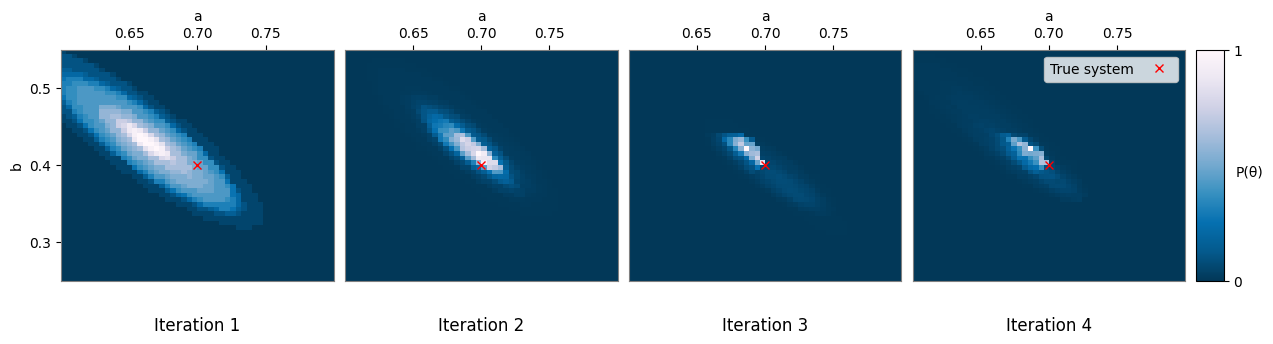

In [28]:
# Set up the grid of plots
n_plots = 4
n_cols = 5
n_rows = 1
gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), gridspec_kw=gridspec)
axes = axes.flatten()

# Plot the fused confidence region from each SPS run, as well as the points sampled from it
skip = 3
for idx in range(n_plots):
    im = axes[idx].imshow(1-fused_ranks_list[skip*idx].T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])
    
    # in_set = sample_fused_rank_tensor(fused_ranks_list[skip*idx], grid_axes, p=0.95)
    # axes[idx].scatter(in_set[:,0], in_set[:,1], c='k', marker='.', s=1)
    axes[idx].set_aspect('auto')
    # axes[idx].set_axis_off()
    axes[idx].set_xlim([0.6,0.8])
    axes[idx].set_ylim([0.25,0.55])
    axes[idx].set_xlabel('a')
    axes[idx].set_ylabel('b')
    axes[idx].set_xticks([0.65,0.7,0.75])
    axes[idx].set_yticks([0.3,0.4,0.5])
    axes[idx].xaxis.set_ticks_position('top')
    axes[idx].xaxis.set_label_position('top')
    if idx != 0: axes[idx].get_yaxis().set_visible(False)
    if idx == 3: axes[idx].get_yaxis().set_visible(False)

    axes[idx].set_title(f"Iteration {1+idx}", y=-0.25)

    axes[idx].plot(a_vals[skip*idx], b, 'rx', label='True system' if idx==3 else None)

    for spine in axes[idx].spines.values():
        spine.set_visible(True)
        spine.set_color(0.5*np.array([1, 1, 1]))





# plt.tight_layout()

axes[0].set_axis_on()
axes[3].legend(markerfirst=False, loc='upper right')

cax = axes[4]
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('P(θ)', rotation=0, labelpad=5)
cbar.ax.set_yticks([0, 1.0])

fig.subplots_adjust(wspace=0.05, hspace=0)
plt.show()


fig.savefig("fusion2.png", dpi=600, bbox_inches='tight')


# plt.show()

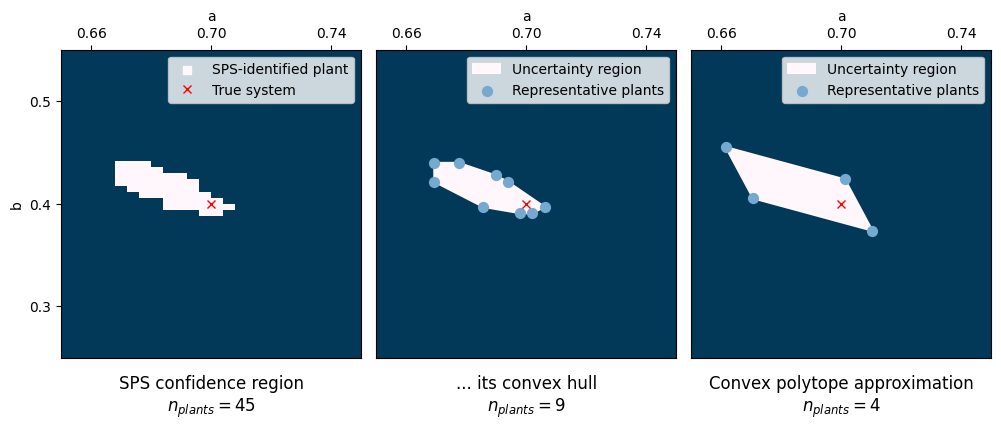

In [27]:
# Set up the grid of plots
n_plots = 3
n_cols = 3
n_rows = 1
gridspec = {'width_ratios': [1, 1, 1]}
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), gridspec_kw=gridspec)
axes = axes.flatten()

p_thresh = 0.95
iter_to_plot = 11

is_in_set = fused_ranks_list[iter_to_plot] < p_thresh

cmap = plt.get_cmap("PuBu_r")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

idx = 0

axes[idx].scatter([], [], color=cmap(1.0), marker='s', label='SPS-identified plant', s=30)
im = axes[idx].imshow(is_in_set.T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])

axes[idx].set_aspect('auto')
axes[idx].set_xlim([0.65,0.75])
axes[idx].set_ylim([0.25,0.55])
axes[idx].set_xlabel('a')
axes[idx].set_ylabel('b')
axes[idx].set_xticks([0.66,0.7,0.74])
axes[idx].set_yticks([0.3,0.4,0.5])
axes[idx].xaxis.set_ticks_position('top')
axes[idx].xaxis.set_label_position('top')
axes[idx].plot(a_vals[0], b, 'rx', label='True system')



# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

idx = 1

pts = np.array([grid_vals[0][is_in_set].T, grid_vals[1][is_in_set].T])
verts, n_verts = get_hull(pts.T)
hull = ConvexHull(verts)
ordered_verts = verts[hull.vertices]


axes[idx].set_facecolor(cmap(0.0))
poly = Polygon(ordered_verts, closed=True, edgecolor=cmap(1.0), facecolor=cmap(1.0), linewidth=1.5, label='Uncertainty region')
axes[idx].add_patch(poly)


axes[idx].set_aspect('auto')
axes[idx].set_xlim([0.65,0.75])
axes[idx].set_ylim([0.25,0.55])
axes[idx].set_xlabel('a')
axes[idx].set_ylabel('b')
axes[idx].set_xticks([0.66,0.7,0.74])
axes[idx].set_yticks([0.3,0.4,0.5])
axes[idx].get_yaxis().set_visible(False)
axes[idx].xaxis.set_ticks_position('top')
axes[idx].xaxis.set_label_position('top')
axes[idx].plot(a_vals[0], b, 'rx')


axes[idx].scatter(verts[:,0], verts[:,1], label='Representative plants', color=cmap(0.5), s=50, marker='o')


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

idx = 2

axes[idx].set_aspect('auto')
axes[idx].set_xlim([0.65,0.75])
axes[idx].set_ylim([0.25,0.55])
axes[idx].set_xlabel('a')
axes[idx].set_ylabel('b')
axes[idx].set_xticks([0.66,0.7,0.74])
axes[idx].set_yticks([0.3,0.4,0.5])
axes[idx].get_yaxis().set_visible(False)
axes[idx].xaxis.set_ticks_position('top')
axes[idx].xaxis.set_label_position('top')
axes[idx].plot(a_vals[0], b, 'rx')


in_set = sample_fused_rank_tensor(fused_ranks_list[iter_to_plot], grid_axes, p=p_thresh)
lrMVEE = LowResMVEE(in_set.T, max_n_verts=4)
V = lrMVEE.vertices

verts, n_verts2 = get_hull(V.T)
hull = ConvexHull(verts)
ordered_verts = verts[hull.vertices]

axes[idx].set_facecolor(cmap(0.0))
poly = Polygon(ordered_verts, closed=True, edgecolor=cmap(1.0), facecolor=cmap(1.0), linewidth=1.5, label='Uncertainty region')
axes[idx].add_patch(poly)

axes[idx].scatter(verts[:,0], verts[:,1], label='Representative plants', color=cmap(0.5), s=50, marker='o')


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

axes[0].set_title("SPS confidence region\n" + rf"$n_{{plants}}={len(pts.T)}$", y=-0.2)
axes[1].set_title("... its convex hull\n" + rf"$n_{{plants}}={n_verts}$", y=-0.2)
axes[2].set_title("Convex polytope approximation\n" + rf"$n_{{plants}}={n_verts2}$", y=-0.2)

axes[0].legend(loc='upper right')
axes[1].legend()
axes[2].legend()

fig.subplots_adjust(wspace=0.05, hspace=0)

fig.savefig("fusion2_unc_region.png", dpi=600, bbox_inches='tight')

plt.show()

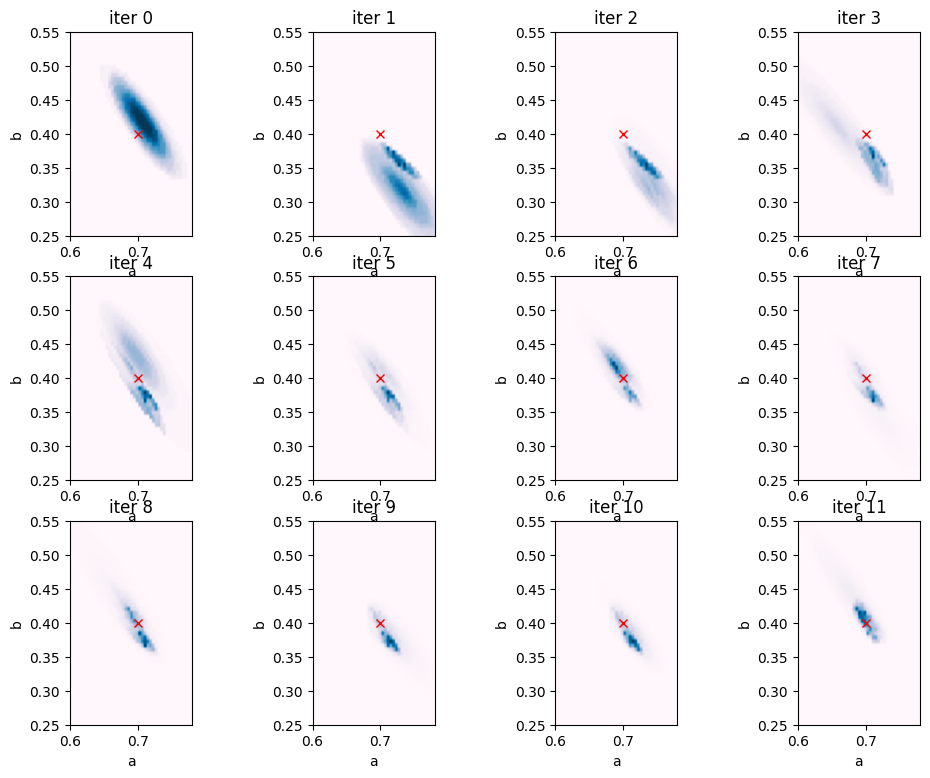

In [552]:
# Set up the grid of plots
n_plots = n_iters
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axes = axes.flatten()

# Plot the fused confidence region from each SPS run, as well as the points sampled from it
for idx in range(n_plots):
    im = axes[idx].imshow(fused_ranks_list[idx].T, cmap="PuBu_r", origin="lower", extent=search_ranges[0]+search_ranges[1])
    
    # in_set = sample_fused_rank_tensor(fused_ranks_list[idx], grid_axes, p=0.95)
    # axes[idx].scatter(in_set[:,0], in_set[:,1], c='k', marker='.', s=1)
    axes[idx].set_aspect('equal')
    # axes[idx].set_axis_off()
    axes[idx].set_xlim([0.6,0.78])
    axes[idx].set_ylim([0.25,0.55])
    axes[idx].set_xlabel('a')
    axes[idx].set_ylabel('b')
    axes[idx].set_title(f"iter {idx}")
    axes[idx].plot(a_vals[idx], b, 'rx')

# plt.tight_layout()
plt.show()

#### 3D system
##### Generate data
Run the ARMAX system for a few iterations, successively computing and fusing the confidence regions.

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ define system and generate data

a1 = -0.9
a2 = -0.1
b1 = 0.8
n_a = 2
n_b = 1

A = [1, -a1, -a2]
B = [0, b1]
C = [1, 0.2, 0.04]
F = ([0.3, 0.2], [1])
L = ([1], [1])
armax_model = ARMAX(A, B[1:], C, F[0], L[0])

search_ranges = [[-2, 0], [-1, 1], [0.1, 1]]
search_resolutions = [21, 21, 10]
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_resolutions[i]) for i in range(n_a+n_b)]
fused_ranks_list = []
n_iters = 12

for i in range(n_iters):

    # ~~~~~~~~~~~ run the system, gather input/output data
    n_samples = 200
    R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS
    m = 20
    q = 1
    model = SPS_indirect_model(m, q, n_samples-1)
    new_ranks = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)

    # ~~~~~~~~~~~ fuse this run's SPS confidence region with previous ones
    if i == 0:
        fused_ranks = new_ranks
    else:
        fused_ranks = fuse_ranks(new_ranks, old_ranks) # e.g. set n=min(i,3) to not take more than 3 past runs into account

    # ~~~~~~~~~~~ store results

    a_vals.append(a)
    fused_ranks_list.append(fused_ranks)
    old_ranks = fused_ranks

##### Plot

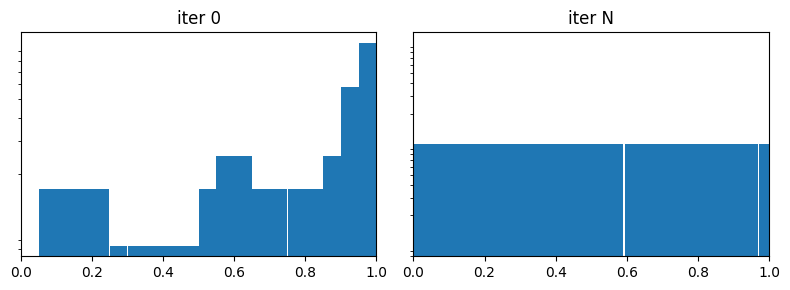

In [8]:
fig,axes = plt.subplots(ncols=2,nrows=1,figsize=(8, 3))

values0, counts0 = np.unique(np.round(fused_ranks_list[0],3), return_counts=True)
counts0 = counts0 / counts0[:-1].max()

axes[0].bar(values0[0:-1], counts0[0:-1], align='edge', label='iter 0', width=(values0[1:]-values0[:-1])*0.99, alpha=1)
axes[0].set_yscale('log')
axes[0].set_xlim([0,1])
axes[0].set_yticks([])
axes[0].set_title('iter 0')

valuesN, countsN = np.unique(np.round(fused_ranks_list[-1],3), return_counts=True)
countsN = countsN / countsN[:-1].max()

axes[1].bar(valuesN[0:-1], countsN[0:-1], align='edge', label='iter 0', width=(valuesN[1:]-valuesN[:-1])*0.99, alpha=1)
axes[1].set_yscale('log')
axes[1].set_xlim([0,1])
axes[1].set_yticks([])
axes[1].set_title('iter N')

plt.tight_layout()
plt.show()


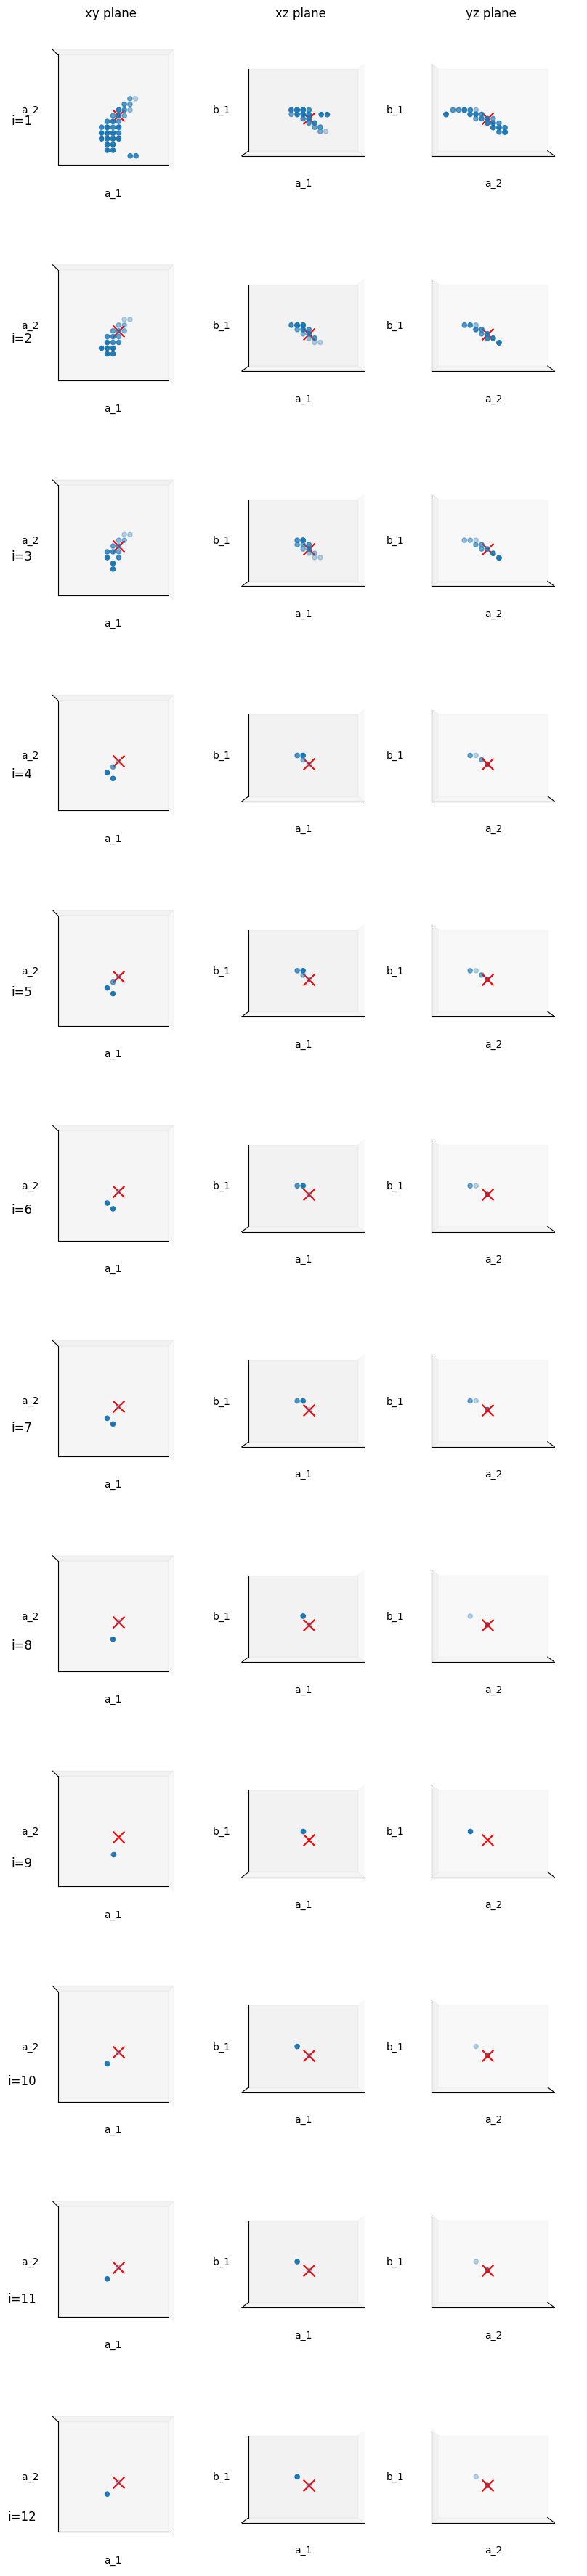

In [9]:
x_lb = -2
x_ub =  0
y_lb = -1
y_ub =  1
z_lb =  0
z_ub =  2

fig, axes = plt.subplots(n_iters, 3, subplot_kw={'projection': '3d'}, figsize=(8,n_iters*3))

for i in range(n_iters):
    for j in range(3):
        in_set = sample_fused_rank_tensor(fused_ranks_list[i], grid_axes, p=0.95)
        scatter3d(in_set, axes[i][j], j)
        axes[i][j].scatter(a1, a2, b1, c='r', marker='x', s=128)

for i in range(n_iters*3):
    fig.axes[i].set_xlim([x_lb, x_ub])
    fig.axes[i].set_ylim([y_lb, y_ub])
    fig.axes[i].set_zlim([z_lb, z_ub])
    if i >= 3:
        fig.axes[i].set_title(None)
for i in range(n_iters):
    fig.text(0.02, 1 - i * (1/n_iters) - 0.05, f"i={i+1}", ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show(block=True)
plt.switch_backend('inline')